# <center> **Movie Recommendation System**

<div align='center'><img src='https://ml8ygptwlcsq.i.optimole.com/fMKjlhs-GfJ463X-/w:1000/h:600/q:auto/rt:fill/g:ce/https://www.unite.ai/wp-content/uploads/2020/08/RecommendationEngine.png'></div>

### **Import Datasets**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [2]:
!pwd
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
!pwd

/content
/content/drive/My Drive/Colab Notebooks


In [3]:
import numpy as np
import pandas as pd

In [4]:
movies = pd.read_csv('movies.csv')
print('Shape of this dataset :', movies.shape)
movies.head()

Shape of this dataset : (27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.read_csv('ratings.csv')
print('Shape of this dataset :',ratings.shape)
ratings.head()

Shape of this dataset : (20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
tags = pd.read_csv('tags.csv')
print('Shape of this dataset :',tags.shape)
tags.head()

Shape of this dataset : (465564, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


# Basic EDA Checks

Check for missing values

In [7]:
print("Missing values in movies:", movies.isnull().sum())
print("Missing values in ratings:", ratings.isnull().sum())
print("Missing values in tags:", tags.isnull().sum())

Missing values in movies: movieId    0
title      0
genres     0
dtype: int64
Missing values in ratings: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in tags: userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


Summary statistics

In [8]:
print("\nSummary statistics for movies:\n", movies.describe())
print("\nSummary statistics for ratings:\n", ratings.describe())
print("\nSummary statistics for tags:\n", tags.describe())


Summary statistics for movies:
              movieId
count   27278.000000
mean    59855.480570
std     44429.314697
min         1.000000
25%      6931.250000
50%     68068.000000
75%    100293.250000
max    131262.000000

Summary statistics for ratings:
              userId       movieId        rating     timestamp
count  2.000026e+07  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00  1.100918e+09
std    4.003863e+04  1.978948e+04  1.051989e+00  1.621694e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    3.439500e+04  9.020000e+02  3.000000e+00  9.667977e+08
50%    6.914100e+04  2.167000e+03  3.500000e+00  1.103556e+09
75%    1.036370e+05  4.770000e+03  4.000000e+00  1.225642e+09
max    1.384930e+05  1.312620e+05  5.000000e+00  1.427784e+09

Summary statistics for tags:
               userId        movieId     timestamp
count  465564.000000  465564.000000  4.655640e+05
mean    68712.354263   32627.762920  1.298711e+09
std  

Unique values

In [9]:
print("\nUnique genres:", movies['genres'].unique())
print("\nNumber of unique movies:", movies['movieId'].nunique())
print("Number of unique users:", ratings['userId'].nunique())


Unique genres: ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' ...
 'Action|Adventure|Animation|Fantasy|Horror'
 'Animation|Children|Comedy|Fantasy|Sci-Fi'
 'Animation|Children|Comedy|Western']

Number of unique movies: 27278
Number of unique users: 138493


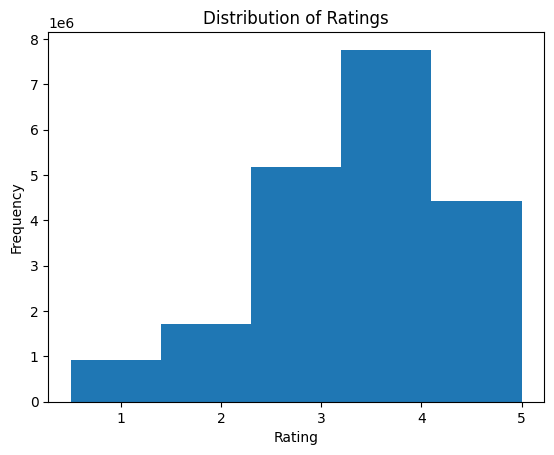

In [10]:
# Distribution of ratings
import matplotlib.pyplot as plt
plt.hist(ratings['rating'], bins=5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

# Popularity-Based Recommender

In [11]:
movie_ratings = ratings.groupby('movieId')['rating'].mean()

# Count number of ratings for each movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count()

# Create a dataframe with movie information and popularity metrics
popularity_df = pd.DataFrame({
    'title': movies.set_index('movieId')['title'],
    'average_rating': movie_ratings,
    'num_ratings': movie_ratings_count
})

# Sort movies by number of ratings and average rating
popularity_df = popularity_df.sort_values(['num_ratings', 'average_rating'], ascending=[False, False])

# Recommend top N most popular movies
N = 10
print(popularity_df.head(N))


                                             title  average_rating  \
movieId                                                              
296                            Pulp Fiction (1994)        4.174231   
356                            Forrest Gump (1994)        4.029000   
318               Shawshank Redemption, The (1994)        4.446990   
593               Silence of the Lambs, The (1991)        4.177057   
480                           Jurassic Park (1993)        3.664741   
260      Star Wars: Episode IV - A New Hope (1977)        4.190672   
110                              Braveheart (1995)        4.042534   
589              Terminator 2: Judgment Day (1991)        3.931954   
2571                            Matrix, The (1999)        4.187186   
527                        Schindler's List (1993)        4.310175   

         num_ratings  
movieId               
296          67310.0  
356          66172.0  
318          63366.0  
593          63299.0  
480          59715.0 

#Content Filter Recommendation

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [13]:
movie_tags = pd.merge(movies, tags, on='movieId', how='left')

# Group tags by movie title and join them into a single string
movie_tags_grouped = movie_tags.groupby('title')['tag'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

# Fill missing tags with empty strings
movie_tags_grouped['tag'] = movie_tags_grouped['tag'].fillna('')

# Initialize TfidfVectorizer and fit to tag data
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_tags_grouped['tag'])

# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=100)
latent_matrix_1 = svd.fit_transform(tfidf_matrix)


In [14]:
# Compute cosine similarity between movies
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_1 = cosine_similarity(latent_matrix_1, latent_matrix_1)

# Function to get movie recommendations based on content filtering
def recommend_movies_content(title, cosine_sim=cosine_sim_1, movies=movies):
    # Get the index of the movie that matches the title
    idx = movies[movies['title'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

# Example recommendation
recommend_movies_content('Pulp Fiction (1994)')

26721                                           Ego (2013)
7295                                 Africa Screams (1949)
14238    Not Quite Hollywood: The Wild, Untold Story of...
10139                                      Airborne (1993)
20753                Bird of the Air, A (Loop, The) (2011)
16776    Midnight Movies: From the Margin to the Mainst...
613                                              Ed (1996)
10946                                  Santa's Slay (2005)
2896                                  Guardian, The (1990)
23507                                      Mar Baum (1997)
Name: title, dtype: object

# Collaborative Filtering Recommender

In [15]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357238 sha256=5ba4ea3b6906fa059eed5879fc61f5d9b4e89c3689f94a1d1d949e3bbc7b4e72
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [16]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import pandas as pd
from sklearn.decomposition import IncrementalPCA

In [ ]:
# Load the dataset
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Use the SVD algorithm
svd = SVD()

# Fit the SVD model to the data
trainset = data.build_full_trainset()
svd.fit(trainset)

# Create a DataFrame of predictions
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()
predictions = pd.DataFrame([[svd.predict(uid, iid).est for iid in movie_ids] for uid in user_ids], index=user_ids, columns=movie_ids)

print('Shape of this DataFrame :', predictions.shape)

# De-mean the data (subtract mean rating for each user)
predictions_demeaned = predictions.sub(predictions.mean(axis=1), axis=0)

# Check the number of features in the DataFrame
num_features = predictions_demeaned.shape[1]
print(f'Number of features: {num_features}')

# Make sure n_components is less than the number of features
n_components = min(num_features, 100)

# Apply IncrementalPCA for dimensionality reduction
ipca = IncrementalPCA(n_components=n_components)
latent_matrix_2 = ipca.fit_transform(predictions_demeaned)

# Print the shape of the latent matrix
print('Shape of the latent matrix:', latent_matrix_2.shape)

In [ ]:
from surprise.model_selection import cross_validate

# Evaluate the SVD model using cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the average RMSE and MAE scores
print('Average RMSE:', results['test_rmse'].mean())
print('Average MAE:', results['test_mae'].mean())


# Matrix Factorization

In [ ]:
# Compute cosine similarity between users
cosine_sim_2 = cosine_similarity(latent_matrix_2, latent_matrix_2)

def recommend_movies_collaborative(user_id, cosine_sim=cosine_sim_2, ratings=ratings, movies=movies):
    # Get the index of the user
    user_idx = ratings['userId'].unique().tolist().index(user_id)

    # Get the pairwise similarity scores of all users with that user
    sim_scores = list(enumerate(cosine_sim[user_idx]))

    # Sort the users based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar users (excluding the user itself)
    sim_scores = sim_scores[1:11]

    # Get the user indices
    user_indices = [i[0] for i in sim_scores]

    # Get the movies that the similar users have rated highly
    recommended_movie_ids = []
    for user_index in user_indices:
        similar_user_id = ratings['userId'].unique()[user_index]
        movies_rated_by_similar_user = ratings[ratings['userId'] == similar_user_id].sort_values('rating', ascending=False)
        recommended_movie_ids.extend(movies_rated_by_similar_user['movieId'].head(5).tolist())

    # Remove duplicates and movies already rated by the user
    recommended_movie_ids = list(set(recommended_movie_ids))
    movies_already_rated = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    recommended_movie_ids = [movie_id for movie_id in recommended_movie_ids if movie_id not in movies_already_rated]

    # Return the titles of the recommended movies
    return movies[movies['movieId'].isin(recommended_movie_ids)]['title']

# Example recommendation for user with ID 1
recommend_movies_collaborative(1)


In [ ]:
from surprise.model_selection import cross_validate

# Evaluate the SVD model using cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the average RMSE and MAE scores
print('Average RMSE:', results['test_rmse'].mean())
print('Average MAE:', results['test_mae'].mean())


In [ ]:
def recommend_movies_hybrid(user_id, title, top_n=10,
                           content_weight=0.5, collaborative_weight=0.5):
    # Content-based recommendations
    content_recs = recommend_movies_content(title)
    content_recs_ids = movies[movies['title'].isin(content_recs)]['movieId'].tolist()

    # Collaborative filtering recommendations
    collab_recs = recommend_movies_collaborative(user_id)
    collab_recs_ids = movies[movies['title'].isin(collab_recs)]['movieId'].tolist()

    # Combine recommendations
    all_recs = content_recs_ids + collab_recs_ids
    unique_recs = list(set(all_recs))

    # Score recommendations
    scored_recs = []
    for movie_id in unique_recs:
        content_score = 0
        collab_score = 0
        if movie_id in content_recs_ids:
            content_score = 1 / (content_recs_ids.index(movie_id) + 1)
        if movie_id in collab_recs_ids:
            collab_score = 1 / (collab_recs_ids.index(movie_id) + 1)

        total_score = (content_weight * content_score) + (collaborative_weight * collab_score)
        scored_recs.append((movie_id, total_score))

    # Sort recommendations by score
    scored_recs.sort(key=lambda x: x[1], reverse=True)

    # Return top N recommendations
    top_movie_ids = [rec[0] for rec in scored_recs[:top_n]]
    return movies[movies['movieId'].isin(top_movie_ids)]['title']

# Example hybrid recommendation for user 1 who liked "Pulp Fiction"
recommend_movies_hybrid(1, "Pulp Fiction (1994)")
